# Introduction

This Image model is made on deep learning model based on CNN and RNN attention mechanism.

In [1]:
import glob 
import string 
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from PIL import Image


### Dataset Loading

Used the dataset at these location 
https://www.kaggle.com/datasets/adityajn105/flickr8k

In [2]:
image_path = "../Dataset/Images/"
captions_path = "../Dataset/captions.txt"

data = pd.read_csv(captions_path)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


(8091,)


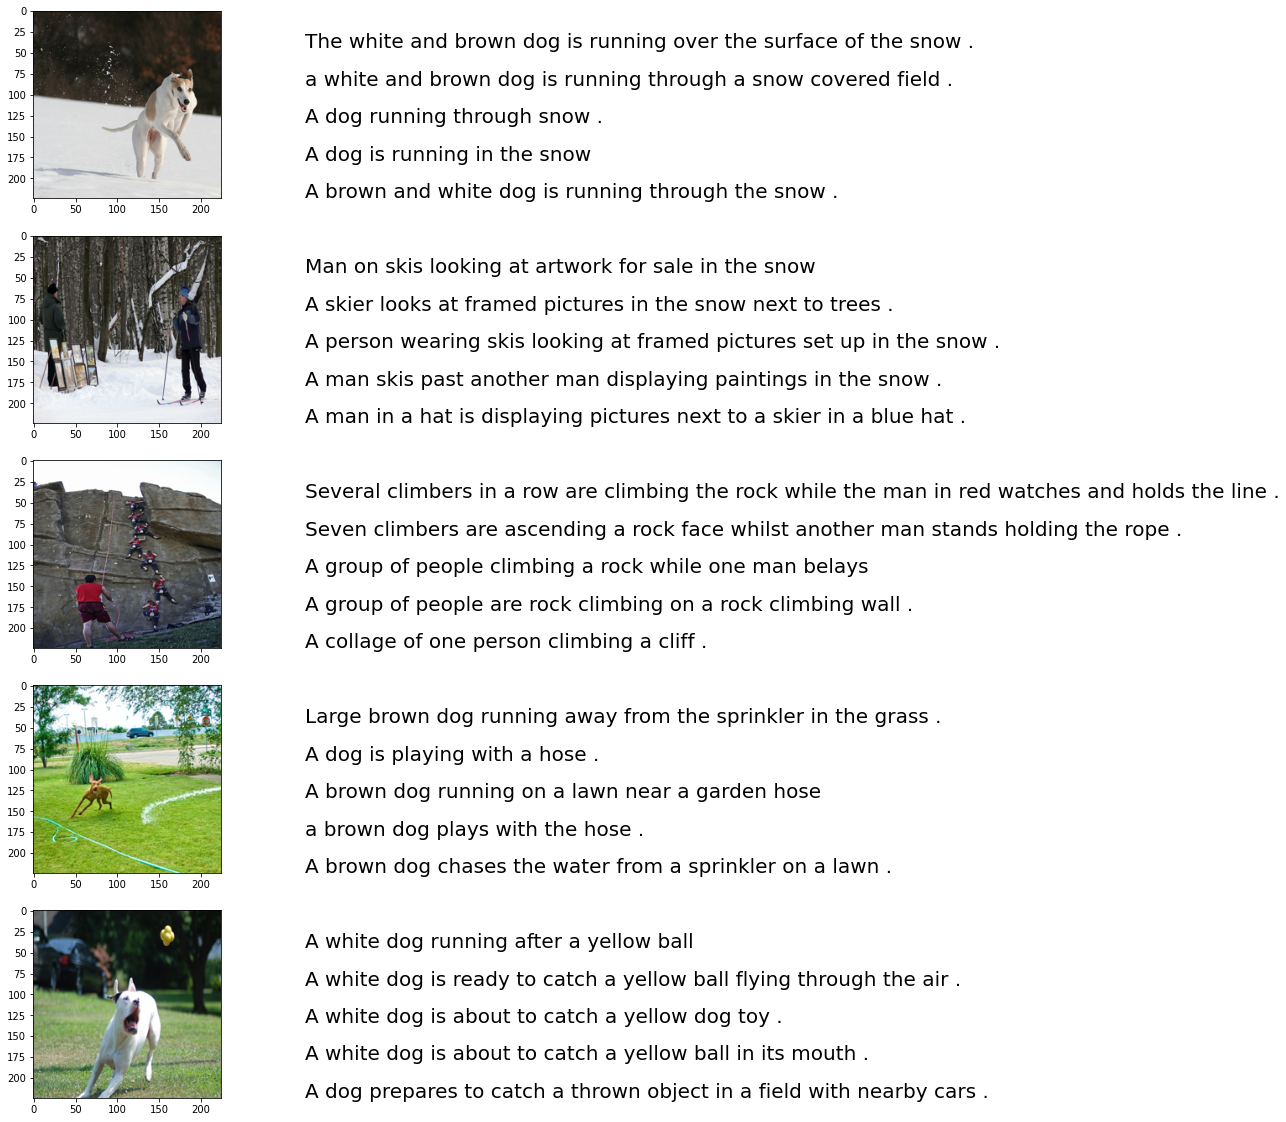

In [3]:
# plot figures 
target_size = (224,224)

unique_files = np.unique(data.image.values)
fig = plt.figure(figsize=(10,20))
for j,file in enumerate(unique_files[10:15]):
    img  = image_path + "/" + file
    captions = list(data["caption"].loc[data["image"] == file].values)
    image_data = Image.open(img)
    image_data = image_data.resize(target_size)
    ax = fig.add_subplot(5,2,j*2+1)
    ax.imshow(image_data)


    ax = fig.add_subplot(5,2,j*2+2)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    
print(unique_files.shape)

### Data Cleaning 
* Remove punctuations
* Convert captions to lowercase
* Create a list which contains all the captions & path


In [4]:
## Data Preprocessing and cleaning 
vocab  = []
for text in data.caption.values:
    vocab.extend(text.split(" "))
len(set(vocab))

def remove_punctuation(text):
    return text.translate(string.punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   
   data["caption"].iloc[i] = newcaption
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of sta...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden c...


In [5]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of sta...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden c...


In [6]:
##  container to store all image captions and image paths 
all_captions = []
for caption in data["caption"]:
    caption = "<start>" + caption + " <end>"
    all_captions.append(caption)

all_images = []
for image in data["image"]:
    all_images.append( image_path + image )
all_captions[:10]


['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> Two dogs of different breeds looking at each other on the road <end>',
 '<start> Two dogs on pavement moving toward each other <end>']

In [7]:
## shuffle and select only first 40000 out of 40455
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

def shuffle_deliminate(num, all_captions,all_images):
    all_captions,all_images = shuffle(all_captions,all_images,random_state = 1)
    train_captions = all_captions[:num]
    train_images = all_images[:num]
    return train_images,train_captions

train_images,train_captions= shuffle_deliminate(40000,all_captions,all_images)
len(train_images)


40000

### Load the pretrained ResNet50 model

* To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.
* The shape of the output of this layer is 7x7x2048.
* Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 49, 2048) 

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Load ResNet50 model with include_top=False
base_model = ResNet50(include_top=False)

# Create a new model by removing the last layer
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# Verify the model summary
model.summary()



_________________
conv3_block4_add (Add)          (None, None, None, 5 0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, None, None, 5 0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, None, None, 2 131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, None, None, 2 0           conv4_block1_1_bn[0][0]   

### Dataset Creation
* Create a function which maps the image path to their feature
* Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset
* The shape of each image in the dataset after building should be (batch_size, 7*7, 2048) 

In [9]:
## img load and store
from tensorflow.keras.preprocessing.image import load_img,img_to_array
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, [224, 224])
  img = tf.keras.applications.resnet50.preprocess_input(img)
  
  return img, image_path


In [10]:
## lets create dataset 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
encode_train =  sorted(set(train_images))
print(encode_train[0])
img_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = img_dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
image_dataset = image_dataset.batch(64)



../Dataset/Images/1000268201_693b08cb0e.jpg


In [11]:
from tqdm import tqdm

In [12]:
img_features = {}
for img, path in tqdm(image_dataset):
    batch_features = model(img)
    print(batch_features.shape)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
        


100%|██████████| 127/127 [22:21<00:00, 10.56s/it](27, 7, 7, 2048)



### Tokenization and preprocessing 
* Create the tokenized vectors by tokenizing the captions for ex :split them using spaces & other filters.
* This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.
* Replace all other words with the unknown token "unk"
* Create word-to-index and index-to-word mappings.
* Pad all sequences to be the same length as the longest one
* train validation split of data into 80:20


In [11]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')



In [12]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [13]:
## create train validation split
from sklearn.model_selection import train_test_split

img_name_train, img_name_val, cap_train, cap_val = train_test_split(train_images,cap_vector, test_size=0.2, random_state=0)



In [14]:
## define paramss for the training 
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 49

In [15]:
## create tf.data.dataset for our model
def map_func(image_path,cap):
    image_tensor = np.load(image_path.decode('utf-8')+ '.npy')
    return image_tensor,cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
 sample_batch_img,  sample_batch_cap = next(iter(dataset))
 sample_batch_img.shape

TensorShape([64, 49, 2048])

### CNN based Encoder 
* The encoder parts involve the convolution of the input image with the help of various convolution, max pooling, and fully connected layers.
* The final output of the encoder part will be the generation of the feature vector.
 Important aspects of Encoder
* The CNN-based encoder produces the feature vector which is the encoded representation of the input image.
* The resulting feature vector does not change at each timestamp.
* Therefore we need to pass this vector to the **attention model along with the hidden state of the decoder to create the context vector**.



In [17]:
 
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 7*7, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features


In [18]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

###RNN decoder using attention 
* Input to GRU : Context vector (from attention model) concatenated with embedded vector (embedding layer). Output of this concatenation layer is fed to GRU as input
* Embedding layer present inside the decoder takes the input sequence preprocessed and transformed such that all samples have equal sequence length - through padding followed by masking). Embedding layer transforms this into an embedded vector.
* Concatenation layer contains : Embedded vector (output of embedding layer) along with the Context vector (output of attention model)


In [19]:
#RNN decoder using attention 
class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
  

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)


### Why Masking ?

 In natural language processing tasks, sequences often have different lengths, and during training, it's common to pad shorter sequences with zeros to match the length of the longest sequence in the batch. Padding can result in a risk of adding penalty to the model.Once the padding is done, we need to apply 'masking'. Without masking, the model will **consider the padded input at that timestep, which will contribute to an increased loss. Through masking we need to inform the model to **ignore whenever a padded input is passed at a timestep**, hinting that this part of the input is padded.






In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    #This mask will be used to exclude padding tokens (where real is 0) from contributing to the      loss
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #element wise multiplication is done to avoid the loss due to padding 

    return tf.reduce_mean(loss_)

### Model Training 


In [24]:
##
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    # because the captions are not related from image to image

    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [33]:
from  tqdm import tqdm
import time
EPOCHS = 20
for epoch in tqdm(range(0, EPOCHS)):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss
       print(total_loss)
    #    if batch % 100 == 0:
    #             print ('Epoch {} Batch {} Loss {:.4f}'.format(
    #                 epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

8.595236, shape=(), dtype=float32)
tf.Tensor(29.00996, shape=(), dtype=float32)
tf.Tensor(29.443401, shape=(), dtype=float32)
tf.Tensor(29.90548, shape=(), dtype=float32)
tf.Tensor(30.352066, shape=(), dtype=float32)
tf.Tensor(30.825916, shape=(), dtype=float32)
tf.Tensor(31.254774, shape=(), dtype=float32)
tf.Tensor(31.67228, shape=(), dtype=float32)
tf.Tensor(32.094982, shape=(), dtype=float32)
tf.Tensor(32.509644, shape=(), dtype=float32)
tf.Tensor(32.991623, shape=(), dtype=float32)
tf.Tensor(33.452408, shape=(), dtype=float32)
tf.Tensor(33.888363, shape=(), dtype=float32)
tf.Tensor(34.28738, shape=(), dtype=float32)
tf.Tensor(34.68747, shape=(), dtype=float32)
tf.Tensor(35.105762, shape=(), dtype=float32)
tf.Tensor(35.55249, shape=(), dtype=float32)
tf.Tensor(36.02776, shape=(), dtype=float32)
tf.Tensor(36.464684, shape=(), dtype=float32)
tf.Tensor(36.92025, shape=(), dtype=float32)
tf.Tensor(37.327503, shape=(), dtype=float32)
tf.Tensor(37.790684, shape=(), dtype=float32)
tf.Tens

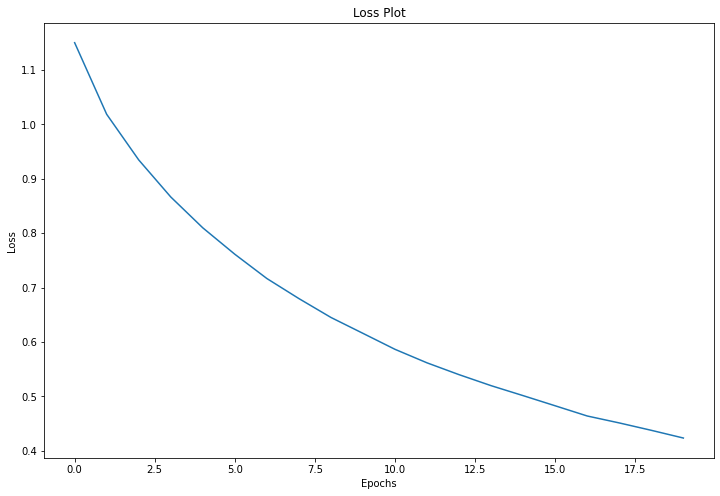

In [36]:
##plot the errors
plt.figure(figsize=(12, 8))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Model Evaluation

* Define your evaluation function using greedy search

* Define your evaluation function using beam search ( optional)

* Test it on a sample data using BLEU score


In [56]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = tf.zeros((1, units))
    # hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [57]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

BELU score: 5.072841446586652e-76
Real Caption: Two white dogs are playing in the snow
Prediction Caption: two white dogs are outside in snow


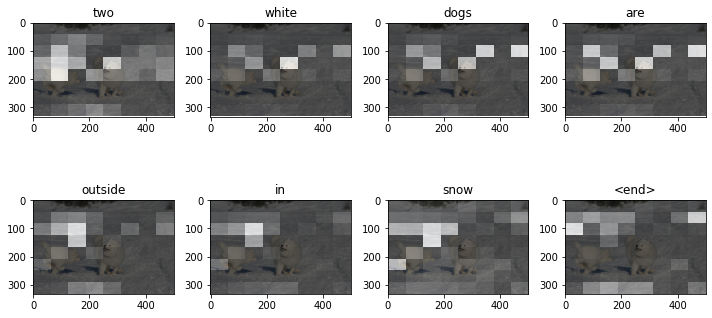

In [62]:
from nltk.translate.bleu_score import sentence_bleu
rid = np.random.randint(0, len(img_name_val))
image = '../Dataset/Images/2319175397_3e586cfaf8.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot,_ = evaluate(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = 'Two white dogs are playing in the snow'

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

Real Caption: brown dog is trying to <unk> his orange ball that has fallen in dirt hole
Prediction Caption: brown dog digging for ball


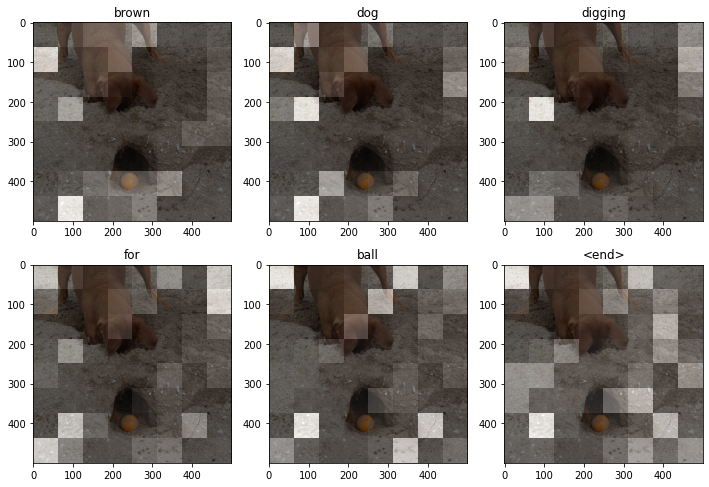

time took to Predict: 3 sec


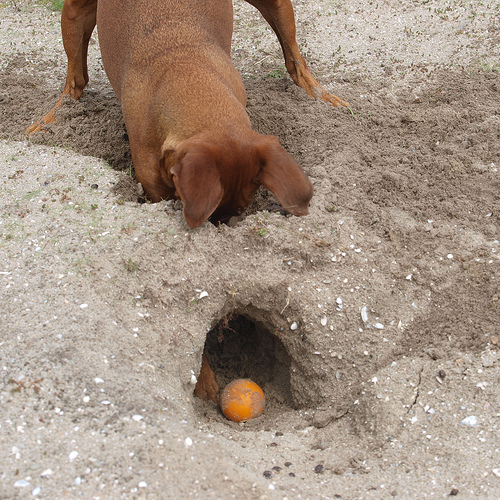

In [63]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot, _ = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])